In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

# Harris corner detection

In [ ]:
# Utility Function
def load_and_gray(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img, gray

def harris_corners(gray_img, threshold=0.01):
    gray = np.float32(gray_img)
    dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
    dst = cv2.dilate(dst, None)
    corners = np.argwhere(dst > threshold * dst.max())
    return corners

def draw_corners(img, corners):
    img_copy = img.copy()
    for y, x in corners:
        cv2.circle(img_copy, (x, y), 3, (0, 0, 255), -1)
    return img_copy

def extract_patch(img, center, size):
    y, x = center
    half = size // 2
    return img[max(y-half,0):y+half+1, max(x-half,0):x+half+1]

In [ ]:
# Load image, try sample images
# To prevent the small image from being covered, put the image that is larger in both length and width into img2.
img1, gray1 = load_and_gray('/content/drive/MyDrive/photos/leftImage.png')
img2, gray2 = load_and_gray('/content/drive/MyDrive/photos/rightImage.png')

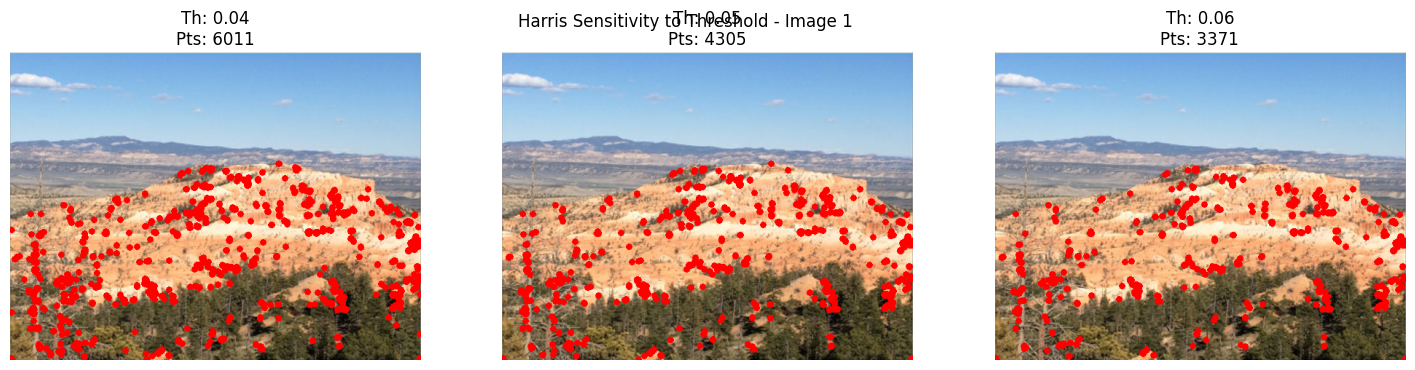

In [ ]:
# Multi-threshold corner detection display
""" In this step, I tried thresholds of 0.04-0.06
 and finally chose a more balanced 0.05 as the final threshold."""

thresholds = [0.04, 0.05, 0.06]
fig, axs = plt.subplots(1, len(thresholds), figsize=(18, 4))

for i, th in enumerate(thresholds):
    corners1 = harris_corners(gray1, threshold=th)
    temp = draw_corners(img1, corners1)
    axs[i].imshow(cv2.cvtColor(temp, cv2.COLOR_BGR2RGB))
    axs[i].set_title(f'Th: {th}\nPts: {len(corners1)}')
    axs[i].axis('off')

plt.suptitle("Harris Sensitivity to Threshold - Image 1")
plt.show()

In [ ]:
# Set the threshold to 0.05 for final processing
corners1 = harris_corners(gray1, threshold=0.02)
corners2 = harris_corners(gray2, threshold=0.02)

print(f"Final corner selection | Image left: {len(corners1)} points | Image right: {len(corners2)} points")

Final corner selection | Image left: 13666 points | Image right: 13961 points


In [ ]:
# Visualize the final corner points
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(cv2.cvtColor(draw_corners(img1, corners1), cv2.COLOR_BGR2RGB))
axs[0].set_title("Harris Corners - Image 1")
axs[1].imshow(cv2.cvtColor(draw_corners(img2, corners2), cv2.COLOR_BGR2RGB))
axs[1].set_title("Harris Corners - Image 2")
for ax in axs: ax.axis("off")
plt.show()

# Patch Sensitivity Analysis（image 1）
patch_sizes = [5, 9, 15]
sampled1 = random.sample(list(corners1), 5) # Randomly select 5 corners for analysis

fig, axs = plt.subplots(len(sampled1), len(patch_sizes), figsize=(10, 8))
for i, pt in enumerate(sampled1):
    for j, size in enumerate(patch_sizes):
        patch = extract_patch(gray1, pt, size)
        axs[i, j].imshow(patch, cmap='gray')
        axs[i, j].set_title(f'{size}x{size}')
        axs[i, j].axis('off')
plt.suptitle("Patch Sizes - Image 1")
plt.tight_layout()
plt.show()

In this step, I tried thresholds of 0.04-0.06 and finally chose a more balanced 0.05 as the final threshold.

At the same time, as you can see, I also tried three different cases of patch_sizes = [5, 9, 15]

# Compute SIFT descriptors

In [ ]:
# define functon which can convert harris points into a cv2.KeyPoint object
def to_keypoints(corner_array):
    return [cv2.KeyPoint(x=float(x), y=float(y), size=9) for y, x in corner_array] # Changed _size to size

In [ ]:
# creat sift objection
sift = cv2.SIFT_create()

# convert harris to keypoints
kp1 = to_keypoints(corners1)
kp2 = to_keypoints(corners2)

# Use the SIFT descriptor to calculate
kp1, des1 = sift.compute(gray1, kp1)
kp2, des2 = sift.compute(gray2, kp2)

print(f"Descriptor shape: Image1 = {des1.shape}, Image2 = {des2.shape}")


# Compute the distances between every descriptor in image 1 with every descriptor in image 2.



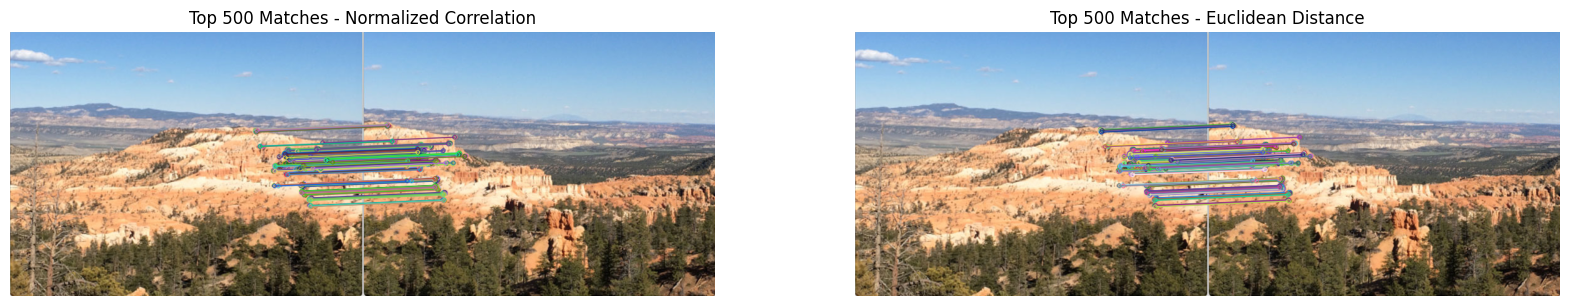

In [ ]:
# Normalize descriptors
des1_norm = normalize(des1, axis=1)
des2_norm = normalize(des2, axis=1)

### A. Normalized Correlation (Cosine Similarity)
# Compute pairwise cosine similarity
cos_sim_matrix = cosine_similarity(des1_norm, des2_norm)

# For each descriptor in des1, find the most similar in des2
matches_corr = []
for i in range(cos_sim_matrix.shape[0]):
    j = np.argmax(cos_sim_matrix[i])
    sim_score = cos_sim_matrix[i, j]
    # Simulate distance value (1 - similarity) for drawMatches sorting
    matches_corr.append(cv2.DMatch(i, j, 1 - sim_score))

###  B. Euclidean Distance Matching (no crossCheck, no ratio)
# Use BFMatcher to get the closest descriptor only (top-1)
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
raw_matches = bf.knnMatch(des1_norm.astype(np.float32), des2_norm.astype(np.float32), k=1)

# Flatten match list
matches_euc = [m[0] for m in raw_matches]

# Sort both match lists by distance (for fair visualization)
matches_corr = sorted(matches_corr, key=lambda x: x.distance)
matches_euc = sorted(matches_euc, key=lambda x: x.distance)

# Visualization of Distance-Based Matches
img_corr = cv2.drawMatches(img1, kp1, img2, kp2, matches_corr[:500], None, flags=2)
img_euc = cv2.drawMatches(img1, kp1, img2, kp2, matches_euc[:500], None, flags=2)

img_corr_rgb = cv2.cvtColor(img_corr, cv2.COLOR_BGR2RGB)
img_euc_rgb = cv2.cvtColor(img_euc, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.title("Top 500 Matches - Normalized Correlation")
plt.imshow(img_corr_rgb)
plt.axis('off')

plt.subplot(122)
plt.title("Top 500 Matches - Euclidean Distance")
plt.imshow(img_euc_rgb)
plt.axis('off')
plt.show()


As shown in the visualization of the top-500 matches using both normalized correlation and Euclidean distance (after L2 normalization), the selected correspondences are highly similar.


This is expected because, in the absence of any filtering such as Lowe’s ratio test, both metrics tend to favor the same top nearest neighbors, resulting in nearly identical matching patterns.

# Select the best matches and make a sensitivity analysis.

In [ ]:
# define ratio-test matching function
def ratio_test_matcher(des1, des2, kp1, kp2, ratio=0.8, top_k=500):
    # Lowe’s Ratio Test default is 0.8
    bf = cv2.BFMatcher()
    raw_matches = bf.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in raw_matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)

    good_matches = sorted(good_matches, key=lambda x: x.distance)
    return good_matches[:min(len(good_matches), top_k)]


In [ ]:
# Ratio Threshold Sensitivity Analysis (with proper fallback label)
ratios = [0.6, 0.7, 0.8, 0.9]
counts = []

for r in ratios:
    actual_ratio = r
    matches = ratio_test_matcher(des1_norm.astype(np.float32), des2_norm.astype(np.float32), kp1, kp2, ratio=r, top_k=99999)

    # Special handling of the case where ratio = 0.9 and the number of matches is 0
    if r == 0.9 and len(matches) == 0:
        print("Ratio 0.9 yielded 0 matches. Retrying with ratio=1.0...")
        matches = ratio_test_matcher(des1_norm.astype(np.float32), des2_norm.astype(np.float32), kp1, kp2, ratio=1.0, top_k=99999)
        actual_ratio = 1.0

    counts.append(len(matches))
    print(f"Ratio {r} → Used Ratio {actual_ratio}: Retained matches = {len(matches)}")



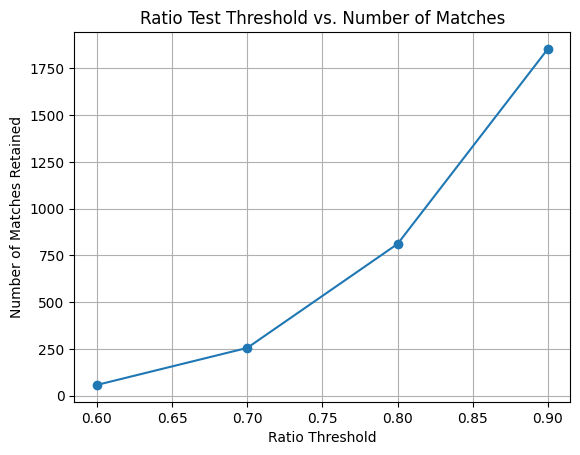

In [ ]:
# Visualization
plt.figure()
plt.plot(ratios, counts, marker='o')
plt.title("Ratio Test Threshold vs. Number of Matches")
plt.xlabel("Ratio Threshold")
plt.ylabel("Number of Matches Retained")
plt.grid(True)
plt.show()


**As shown in the figure, the inflection point is around 0.8, after which the growth rate accelerates sharply. So I choose 0.8.**

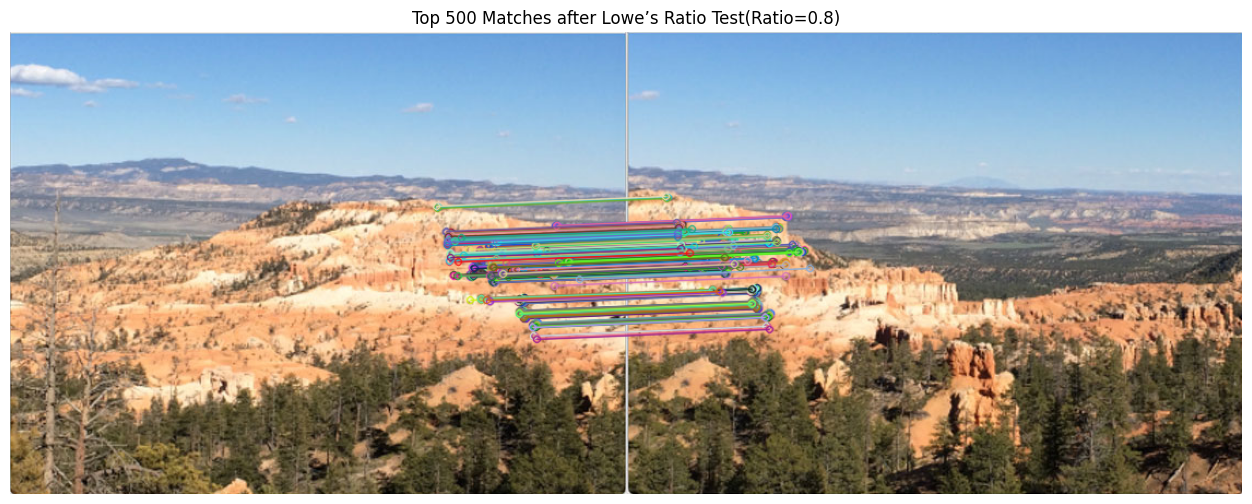

In [ ]:
# Final Match Selection for Visualizatio
ratio_num = 0.8
# if try another images, please choose ratio_num according to the sensitivity analysis
# for the case where ratio = 0.9 and the number of matches is 0, please set ratio_num as 1.0

final_matches = ratio_test_matcher(des1_norm.astype(np.float32), des2_norm.astype(np.float32),
                                   kp1, kp2, ratio=ratio_num, top_k=500)


# Visualize
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, final_matches, None, flags=2)
# Convert to RGB format for display
img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16, 6))
plt.title(f"Top 500 Matches after Lowe’s Ratio Test(Ratio={ratio_num})")
plt.imshow(img_matches_rgb)
plt.axis("off")
plt.show()


 I applied Lowe's ratio test with a threshold of 0.8, which retained 248 matches.

Since the number of filtered matches was already below 500, all were used for subsequent transformation estimation.

# Affine Transformation Estimation with RANSAC

In [ ]:
# Define affine function
def compute_affine_matrix(p1, p2):
    """Least squares estimate of the affine transformation matrix（AX = b）"""
    A = []
    b = []
    for (x, y), (u, v) in zip(p1, p2):
        A.append([x, y, 1, 0, 0, 0])
        A.append([0, 0, 0, x, y, 1])
        b.append(u)
        b.append(v)
    A = np.array(A)
    b = np.array(b)
    x, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    return x.reshape(2, 3)

def apply_affine_transform(pts, M):
    pts_homo = np.hstack([pts, np.ones((pts.shape[0], 1))])
    return (M @ pts_homo.T).T

def custom_ransac_affine(src_pts, dst_pts, num_iter=1000, threshold=3.0):
    best_inliers = []
    best_M = None
    best_residual = np.inf

    for _ in range(num_iter):

        # Sample 3 random pairs

        idx = random.sample(range(len(src_pts)), 3)
        pts1 = src_pts[idx]
        pts2 = dst_pts[idx]

        # Estimate affine
        try:
            M = compute_affine_matrix(pts1, pts2)
        except np.linalg.LinAlgError:
            continue

        # Predict and calculate residuals
        pred = apply_affine_transform(src_pts, M)
        errors = np.linalg.norm(pred - dst_pts, axis=1)
        inliers = errors < threshold

        # Keep model in most inliers
        if np.sum(inliers) > np.sum(best_inliers):
            best_M = M
            best_inliers = inliers
            best_residual = np.mean(errors[inliers] ** 2)

    return best_M, best_inliers, best_residual


In [ ]:
# Get parameters
src_pts = np.float32([kp1[m.queryIdx].pt for m in final_matches])
dst_pts = np.float32([kp2[m.trainIdx].pt for m in final_matches])

M_affine, inliers_mask, residual = custom_ransac_affine(src_pts, dst_pts, num_iter=1000, threshold=3.0)

# Report
print(f"Inliers: {np.sum(inliers_mask)} / {len(final_matches)}")
print(f"Average residual (squared error): {residual:.2f}")
print(f"Estimated Affine Matrix:\n{M_affine}")


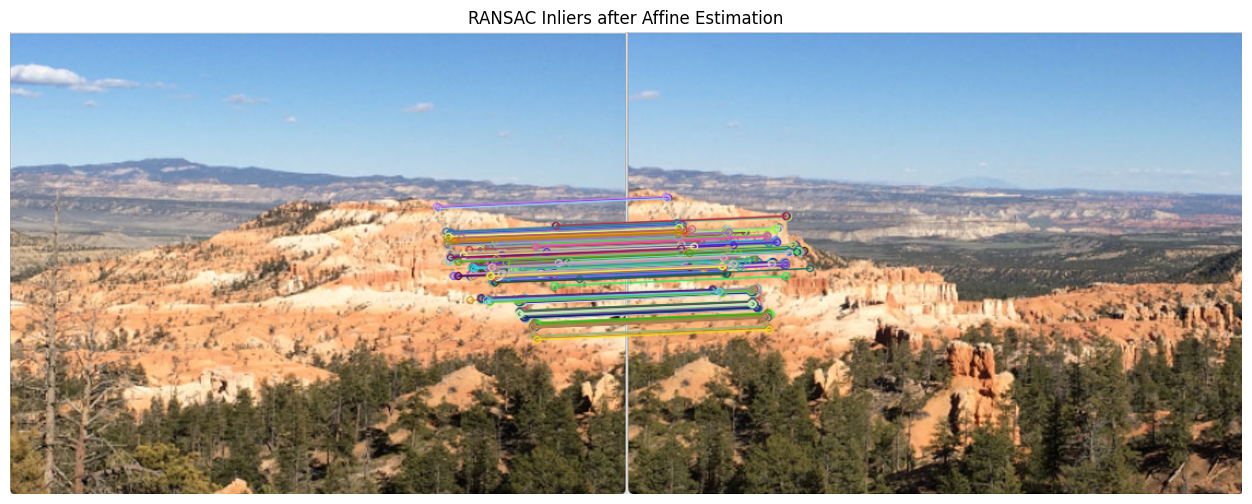

Inlier ratio: 1.00


In [ ]:
# Visualizing Inlier Matches
inlier_matches = [m for m, keep in zip(final_matches, inliers_mask) if keep]
img_inlier_match = cv2.drawMatches(img1, kp1, img2, kp2, inlier_matches, None, flags=2)
img_inlier_match_rgb = cv2.cvtColor(img_inlier_match, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16, 6))
plt.title("RANSAC Inliers after Affine Estimation")
plt.imshow(img_inlier_match_rgb)
plt.axis("off")
plt.show()

print(f"Inlier ratio: {np.sum(inliers_mask) / len(final_matches):.2f}")

The RANSAC-based affine estimation retained 247 out of 248 input matches (99.6% inlier ratio), with a remarkably low mean squared reprojection error of 1.01 pixels.


The estimated affine matrix exhibited a dominant translation component of approximately 353 pixels horizontally and a slight rotation.

# Warp image 2 onto image 1

In [ ]:
# Affine transformation and translation compensation
# Define wrap and overplay function
def warp_and_overlay_affine(img1, img2, M_affine):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Get the transformed coordinates of the four corners of img2
    corners = np.array([
        [0, 0],
        [w2, 0],
        [w2, h2],
        [0, h2]
    ], dtype=np.float32)

    transformed_corners = cv2.transform(np.array([corners]), M_affine)[0]

    # Calculate how big the entire canvas needs to be and how much to offset it
    all_corners = np.vstack((transformed_corners, [[0,0], [w1, 0], [w1, h1], [0, h1]]))
    [x_min, y_min] = np.floor(all_corners.min(axis=0)).astype(int)
    [x_max, y_max] = np.ceil(all_corners.max(axis=0)).astype(int)

    # canvas size
    translation = [-x_min, -y_min]
    canvas_w, canvas_h = x_max - x_min, y_max - y_min

    # Construct translation compensation matrix
    T = np.array([[1, 0, translation[0]], [0, 1, translation[1]]], dtype=np.float32)
    M_translated = T @ np.vstack([M_affine, [0, 0, 1]])

    # warp img2
    warped_img2 = cv2.warpAffine(img2, M_translated[:2], (canvas_w, canvas_h))

    # Place img1 on the canvas
    canvas = warped_img2.copy()
    canvas[translation[1]:translation[1]+h1, translation[0]:translation[0]+w1] = img1

    return canvas



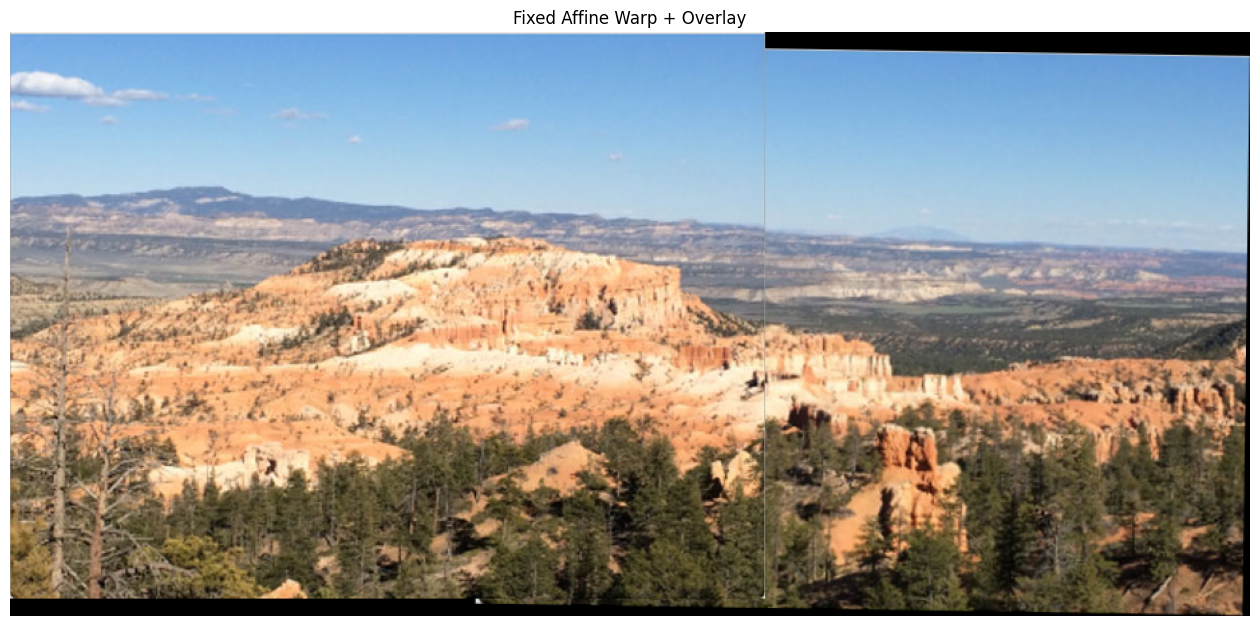

In [ ]:
# Execute stitching
M_inverse = cv2.invertAffineTransform(M_affine)
stitched = warp_and_overlay_affine(img1, img2, M_inverse)

plt.figure(figsize=(16, 8))
plt.title("Fixed Affine Warp + Overlay")
plt.imshow(cv2.cvtColor(stitched, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


As shown, the alignment between the two views is visually consistent, particularly in the skyline and terrain contours. No ghosting or discontinuities are visible, demonstrating the effectiveness of the transformation estimation.

# Evaluation

In [ ]:
# Define ransac affine matrix and ratio test matcher
def ratio_test_matcher(des1, des2, kp1, kp2, ratio=0.8):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    good = [m for m, n in matches if m.distance < ratio * n.distance]
    return good

def ransac_affine_matrix(matches, kp1, kp2, threshold=3.0, num_iter=1000):
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    best_inliers = []
    best_M = None
    best_residual = np.inf

    for _ in range(num_iter):
        if len(pts1) < 3:
            continue
        idx = np.random.choice(len(pts1), 3, replace=False)
        A = np.hstack([pts2[idx], np.ones((3, 1))])
        B = pts1[idx]
        try:
            M = np.linalg.lstsq(A, B, rcond=None)[0].T
        except:
            continue

        pts2_h = np.hstack([pts2, np.ones((pts2.shape[0], 1))])
        pts2_proj = (M @ pts2_h.T).T
        error = np.linalg.norm(pts1 - pts2_proj, axis=1)
        inliers = error < threshold
        residual = np.mean(error[inliers]) if np.any(inliers) else np.inf

        if np.sum(inliers) > len(best_inliers):
            best_M = M
            best_inliers = inliers
            best_residual = residual

    return best_M, best_residual, np.sum(best_inliers)


In [ ]:
# caculate score
def compute_alignment_score(M, matches, kp1, kp2):
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    pts2_h = np.hstack([pts2, np.ones((pts2.shape[0], 1))])
    pts2_proj = (M @ pts2_h.T).T
    residuals = np.linalg.norm(pts1 - pts2_proj, axis=1)
    return np.mean(residuals)


Ratio 0.6: Inliers=55, Avg. residual=0.58
Ratio 0.7: Inliers=251, Avg. residual=0.68
Ratio 0.8: Inliers=96, Avg. residual=1.43
Ratio 0.9: Inliers=485, Avg. residual=1.65


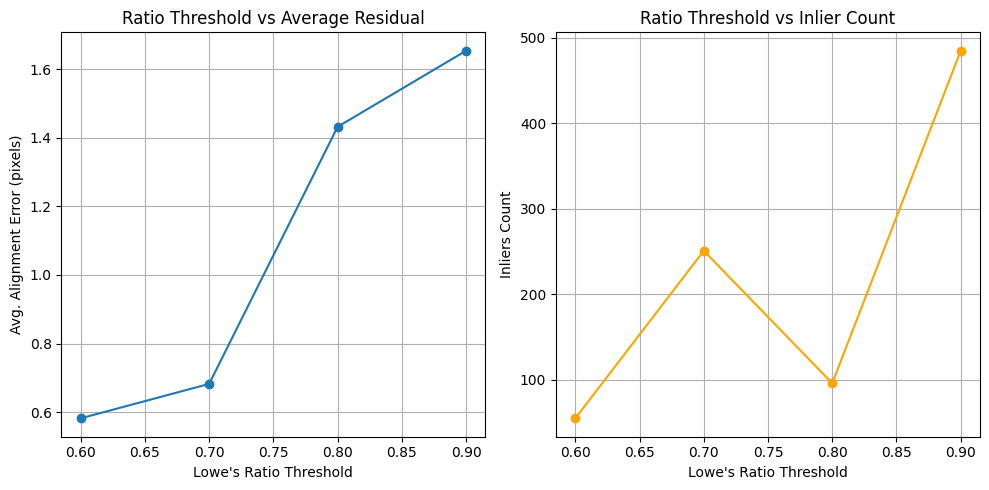

In [ ]:
#  Run multiple ratios
ratios = [0.6, 0.7, 0.8, 0.9]
avg_residuals = []
inlier_counts = []

for r in ratios:
    matches = ratio_test_matcher(des1, des2, kp1, kp2, ratio=r)
    if len(matches) < 3:
        avg_residuals.append(None)
        inlier_counts.append(0)
        continue
    M, res, count = ransac_affine_matrix(matches, kp1, kp2)
    avg_residuals.append(res)
    inlier_counts.append(count)
    print(f"Ratio {r}: Inliers={count}, Avg. residual={res:.2f}")

# Plot results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(ratios, avg_residuals, marker='o')
plt.title("Ratio Threshold vs Average Residual")
plt.xlabel("Lowe's Ratio Threshold")
plt.ylabel("Avg. Alignment Error (pixels)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(ratios, inlier_counts, marker='o', color='orange')
plt.title("Ratio Threshold vs Inlier Count")
plt.xlabel("Lowe's Ratio Threshold")
plt.ylabel("Inliers Count")
plt.grid(True)

plt.tight_layout()
plt.show()


High ratio : More matching points (robust), but lower accuracy.

Low ratio : Higher accuracy matching (lower error), but less stable (too few points).

A balance point between 0.7 and 0.8 can achieve a trade-off between matching quality and quantity.